In [1]:
!pip install diffusers==0.3.0 --q
!pip install transformers scipy ftfy --q
!pip install "ipywidgets>=7,<8" --q
import IPython.display 

In [2]:
!pip install -q torch torchvision
!pip install -q ftfy regex tqdm
!pip install -q git+https://github.com/openai/CLIP.git

In [3]:

import gc
import torch
from PIL import Image
import IPython.display 
from torch import autocast
from tqdm.auto import tqdm
from kaggle_secrets import UserSecretsClient
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler , PNDMScheduler


user_secrets = UserSecretsClient()
Hugging_face  = user_secrets.get_secret("Hugging_id")

2024-04-24 17:58:28.908120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 17:58:28.908221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 17:58:29.035747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
class config : 
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    HEIGHT = 512                        
    WIDTH = 512                         
    NUM_INFERENCE_STEPS = 500            
    GUIDANCE_SCALE = 7.5                
    GENERATOR = torch.manual_seed(48)   
    BATCH_SIZE = 1

In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [6]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=Hugging_face)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=Hugging_face)
vae = vae.to(config.DEVICE)
text_encoder = text_encoder.to(config.DEVICE)
unet = unet.to(config.DEVICE) 

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [10]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [15]:
def generate_image(prompt):

    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    with torch.no_grad():
          text_embeddings = text_encoder(text_input.input_ids.to(config.DEVICE))[0]
    uncond_input = tokenizer(
        [""] * config.BATCH_SIZE, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
          uncond_embeddings = text_encoder(uncond_input.input_ids.to(config.DEVICE))[0]   
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    latents = torch.randn(
      (config.BATCH_SIZE, unet.in_channels, config.HEIGHT // 8, config.WIDTH // 8),
      generator=config.GENERATOR,
    )
    latents = latents.to(config.DEVICE)
    
    scheduler.set_timesteps(config.NUM_INFERENCE_STEPS)
    latents = latents * scheduler.sigmas[0]
    
    with autocast(config.DEVICE):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
        
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

            with torch.no_grad():
                  noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + config.GUIDANCE_SCALE * (noise_pred_text - noise_pred_uncond)

            latents = scheduler.step(noise_pred, i, latents).prev_sample
            
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        image = vae.decode(latents).sample
        
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    display(pil_images[0])
    return pil_images[0]

In [12]:
import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_evl, preprocess = clip.load('ViT-B/32', device=device)
similarity_score = []

def calculate_clip_score(text_prompt):
    # Load and preprocess the image
    image = preprocess(generate_image(text_prompt)).unsqueeze(0).to(device)

    # Encode image and text
    with torch.no_grad():
        image_features = model_evl.encode_image(image)
        text_features = model_evl.encode_text(clip.tokenize([text_prompt]).to(device))
    
    # Calculate cosine similarity
    cosine_similarity = torch.nn.functional.cosine_similarity(image_features, text_features).cpu().numpy()[0]
    print(f'CLIP similarity score: {cosine_similarity}')
    return cosine_similarity

100%|███████████████████████████████████████| 338M/338M [00:16<00:00, 21.6MiB/s]


0it [00:00, ?it/s]

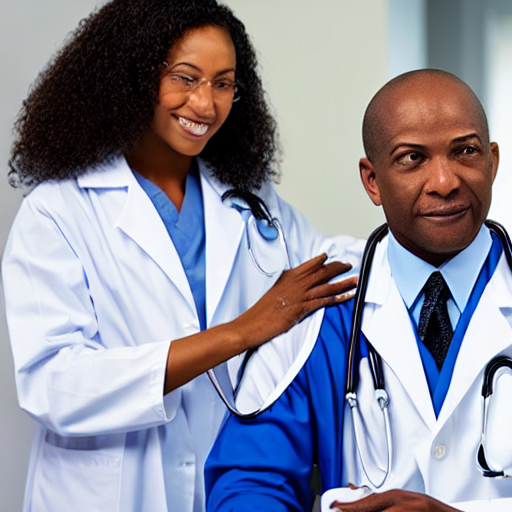

CLIP similarity score: 0.306396484375


In [17]:
prompt = "A black doctor treating a white patient"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

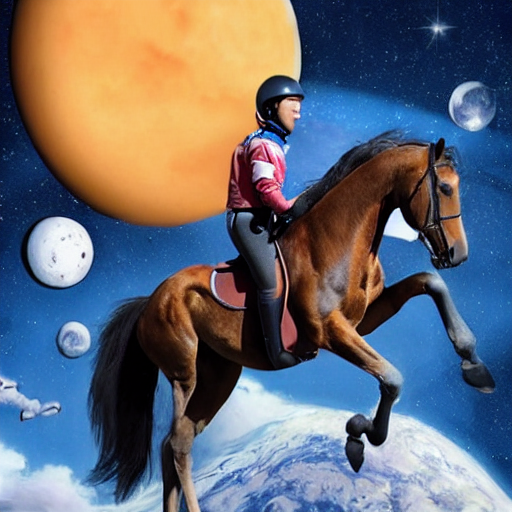

CLIP similarity score: 0.355224609375


In [19]:
prompt = "A horse riding an astronaut"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

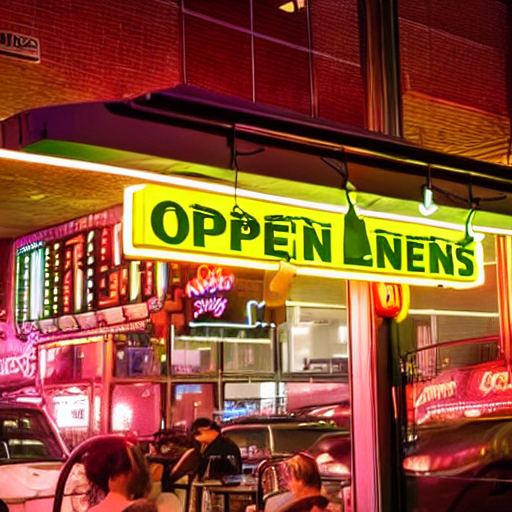

CLIP similarity score: 0.365966796875


In [20]:
prompt = "A neon sign reading 'Open 24 Hours' hangs above a diner at night"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

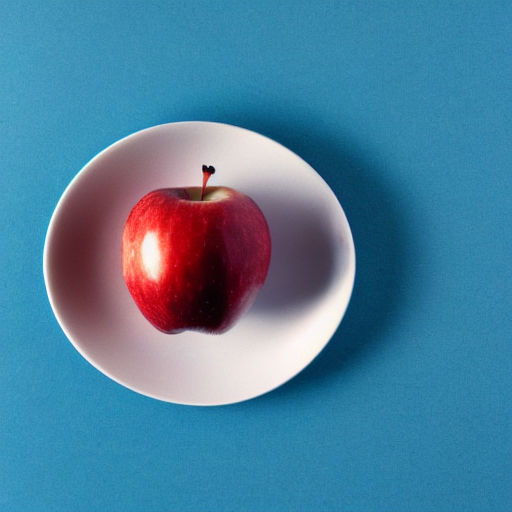

CLIP similarity score: 0.373779296875


In [21]:
prompt = "A red apple on a white plate against a blue background"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

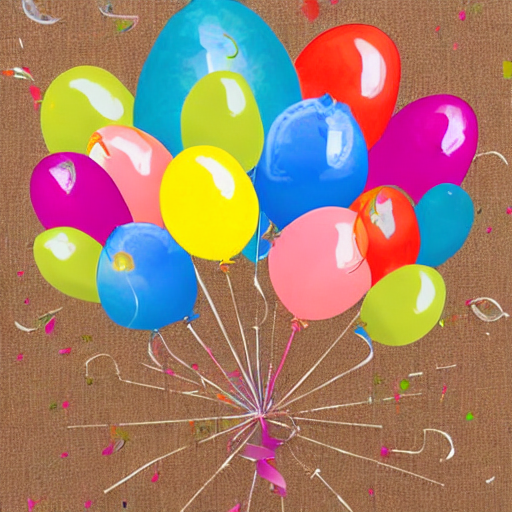

CLIP similarity score: 0.34521484375


In [22]:
prompt = "A 'Happy Birthday' greeting card with colorful balloons and confetti"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

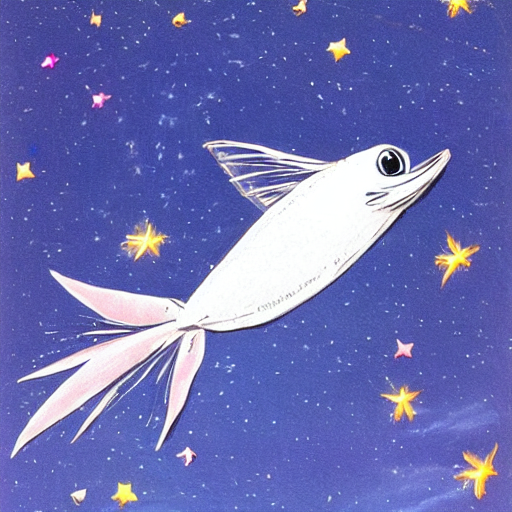

CLIP similarity score: 0.30517578125


In [23]:
prompt = "A flying fish with the wings of a butterfly, swimming through a sky filled with stars"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

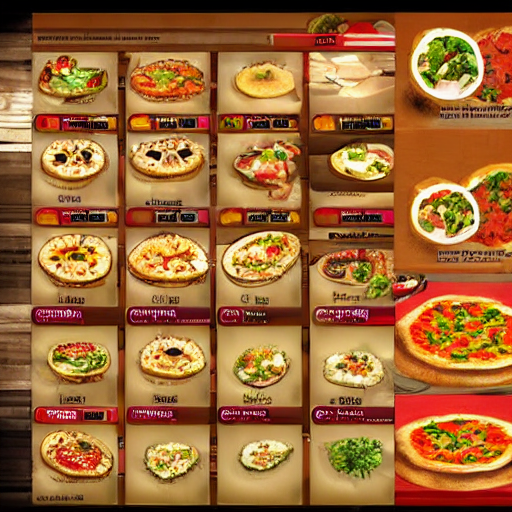

CLIP similarity score: 0.340087890625


In [24]:
prompt = "Create a menu for italian restaurant with various pizzas and prices"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

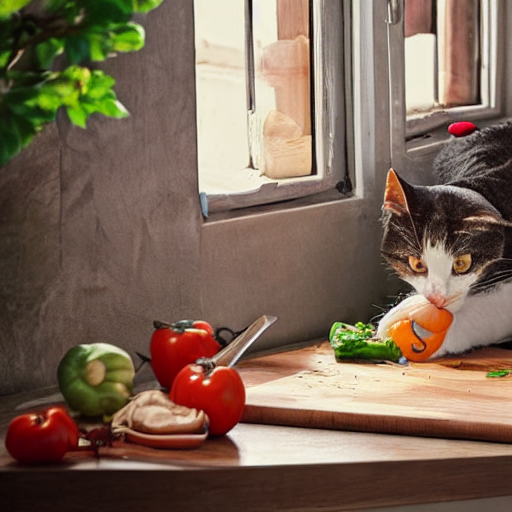

CLIP similarity score: 0.351806640625


In [25]:
prompt = "A kitchen scene with a chef chopping vegetables on a wooden cutting board, a pot boiling on the stove, and a cat lounging by the sunny window"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

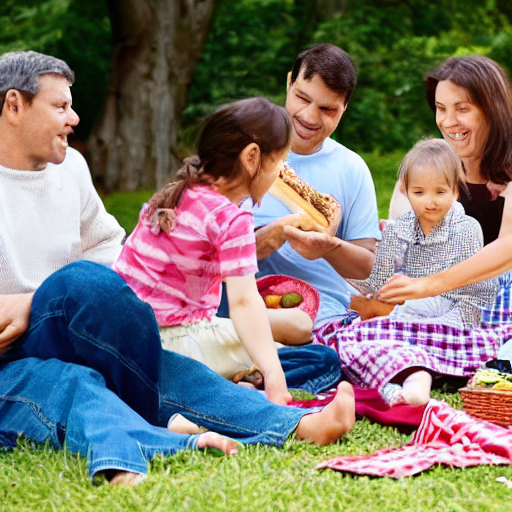

CLIP similarity score: 0.321044921875


In [26]:
prompt = "A family of four having a picnic in a park, with the parents sitting on a checkered blanket while the children play with a Frisbee nearby"
score = calculate_clip_score(prompt)
similarity_score.append(score)

0it [00:00, ?it/s]

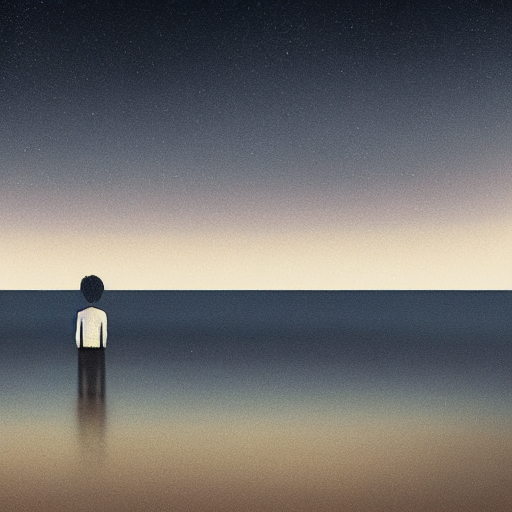

CLIP similarity score: 0.35595703125


In [27]:
prompt = "An abstract representation of loneliness, with a figure standing on a solitary island surrounded by an endless expanse of empty ocean under a starless sky"
score = calculate_clip_score(prompt)
similarity_score.append(score)

In [28]:
print("Average Similarity Score: ", np.average(similarity_score))

Average Similarity Score:  0.3362
